In [61]:
import json
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import ImageDraw

In [62]:
class LungSegmentationDataset(Dataset):
    def __init__(self, image_folder, json_path, transform=None, target_size=(256, 256)):
        self.image_folder = image_folder
        self.transform = transform
        self.target_size = target_size

        # Load JSON annotations
        with open(json_path, 'r') as f:
            self.annotations = json.load(f)

        self.image_files = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and corresponding annotation
        image_info = self.annotations[self.image_files[idx]]
        image_path = os.path.join(self.image_folder, image_info["filename"])
        image = Image.open(image_path).convert("RGB")

        # Create mask from polyline
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        for region in image_info["regions"]:
            points = list(zip(region["shape_attributes"]["all_points_x"],
                              region["shape_attributes"]["all_points_y"]))
            draw.polygon(points, outline=1, fill=1)

        # Resize image and mask to target size
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, mask

In [63]:
# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def crop_to_match(self, tensor, target_tensor):
        """Crop the tensor to match the size of the target_tensor."""
        _, _, h, w = target_tensor.size()
        tensor_h, tensor_w = tensor.size(2), tensor.size(3)
        crop_h = tensor_h - h
        crop_w = tensor_w - w
        return tensor[:, :, :h, :w]

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        up4 = self.crop_to_match(up4, enc4)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.up3(dec4)
        up3 = self.crop_to_match(up3, enc3)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.up2(dec3)
        up2 = self.crop_to_match(up2, enc2)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        up1 = self.crop_to_match(up1, enc1)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

In [64]:
# Define paths and transformations
train_transform = transforms.Compose([transforms.ToTensor()])
image_folder = "../data/masked/annotated"
json_path = "../data/masked/annotated/annotations.json"

# Create dataset and DataLoader
dataset = LungSegmentationDataset(image_folder, json_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize device, model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "../models/lung_segmentation_model.pth")
print("model saved")

Epoch 1/200, Loss: 2.0941
Epoch 2/200, Loss: 2.0837
Epoch 3/200, Loss: 2.0749
Epoch 4/200, Loss: 2.0632
Epoch 5/200, Loss: 2.0513
Epoch 6/200, Loss: 2.0332
Epoch 7/200, Loss: 2.0082
Epoch 8/200, Loss: 1.9676
Epoch 9/200, Loss: 1.8693
Epoch 10/200, Loss: 1.8350
Epoch 11/200, Loss: 1.7699
Epoch 12/200, Loss: 1.7938
Epoch 13/200, Loss: 1.7704
Epoch 14/200, Loss: 1.7171
Epoch 15/200, Loss: 1.6975
Epoch 16/200, Loss: 1.6763
Epoch 17/200, Loss: 1.5107
Epoch 18/200, Loss: 1.4663
Epoch 19/200, Loss: 1.4289
Epoch 20/200, Loss: 1.3866
Epoch 21/200, Loss: 1.0626
Epoch 22/200, Loss: 0.9304
Epoch 23/200, Loss: 0.9662
Epoch 24/200, Loss: 0.7884
Epoch 25/200, Loss: 0.6670
Epoch 26/200, Loss: 0.6655
Epoch 27/200, Loss: 0.5252
Epoch 28/200, Loss: 0.5211
Epoch 29/200, Loss: 0.4550
Epoch 30/200, Loss: 0.4649
Epoch 31/200, Loss: 0.4797
Epoch 32/200, Loss: 0.3958
Epoch 33/200, Loss: 0.3824
Epoch 34/200, Loss: 0.4376
Epoch 35/200, Loss: 0.3454
Epoch 36/200, Loss: 0.3544
Epoch 37/200, Loss: 0.3775
Epoch 38/2

In [1]:
def visualize_prediction(image, mask_pred):
    # Normalize mask to [0, 1]
    mask_pred = mask_pred / mask_pred.max()

    # Convert image to numpy for visualization
    image_np = np.array(image) / 255.0  # Normalize to [0, 1]

    # Premultiply image with the mask
    premultiplied_image = image_np * mask_pred[..., None]

    # Plot original image and premultiplied image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(premultiplied_image)
    axes[1].set_title("Masked Image (Predicted Lung)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [66]:
import os
from IPython import get_ipython
get_ipython().run_line_magic("matplotlib", "inline")
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

def predict_and_visualize_all(base_folder, model, transform, output_base_folder, plot_count=20):
    # Walk through the directory structure of `base_folder`
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):  # Process image files only
                image_path = os.path.join(root, file)

                # Derive output path for the mask
                relative_path = os.path.relpath(root, base_folder)  # Get relative path
                output_dir = os.path.join(output_base_folder, relative_path)
                os.makedirs(output_dir, exist_ok=True)  # Create corresponding output directory
                mask_output_path = os.path.join(output_dir, f"{os.path.splitext(file)[0]}_mask.png")

                try:
                    # Load and process the image
                    image = Image.open(image_path).convert("RGB")
                    print(f"Processing image: {image_path}, Original size: {image.size}")

                    # Transform the image
                    image_tensor = transform(image).unsqueeze(0).to(device)
                    print(f"Input tensor shape: {image_tensor.shape}")

                    # Predict mask
                    with torch.no_grad():
                        mask_pred = model(image_tensor).squeeze(0).squeeze(0).cpu().numpy()
                        print(f"Predicted mask shape: {mask_pred.shape}")

                    # Save predicted mask
                    mask_pred_binary = (mask_pred > 0.5).astype(np.uint8) * 255
                    Image.fromarray(mask_pred_binary).save(mask_output_path)
                    print(f"Mask saved to: {mask_output_path}")
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

    # Visualization: Select 20 random image-mask pairs for plotting
    all_images = []
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                all_images.append(os.path.join(root, file))

    random_samples = random.sample(all_images, min(len(all_images), plot_count))

    for image_path in random_samples:
        relative_path = os.path.relpath(image_path, base_folder)
        mask_path = os.path.join(output_base_folder, os.path.splitext(relative_path)[0] + "_mask.png")

        try:
            # Load original image and mask
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path)

            # Resize original image to match mask size for visualization
            image_resized = image.resize(mask.size, Image.BILINEAR)
            mask_np = np.array(mask) / 255.0  # Normalize mask to [0, 1]

            # Premultiply image with mask
            premultiplied_image = np.array(image_resized) * mask_np[..., None]

            # Plot original and premultiplied images
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(image_resized)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(premultiplied_image.astype(np.uint8))
            axes[1].set_title("Premultiplied Image (Lung Mask)")
            axes[1].axis("off")

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error during visualization for {image_path}: {e}")


Processing image: ../data/equalized\test\NORMAL\IM-0007-0001.jpeg, Original size: (2053, 1818)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked\test\NORMAL\IM-0007-0001_mask.png
Processing image: ../data/equalized\test\NORMAL\IM-0010-0001.jpeg, Original size: (1873, 1478)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked\test\NORMAL\IM-0010-0001_mask.png
Processing image: ../data/equalized\test\NORMAL\IM-0022-0001.jpeg, Original size: (1300, 617)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked\test\NORMAL\IM-0022-0001_mask.png
Processing image: ../data/equalized\test\NORMAL\IM-0023-0001.jpeg, Original size: (2022, 1384)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked\test\NORMAL\IM-0023-0001_mask.png
Processing image: ../data/equalized\t

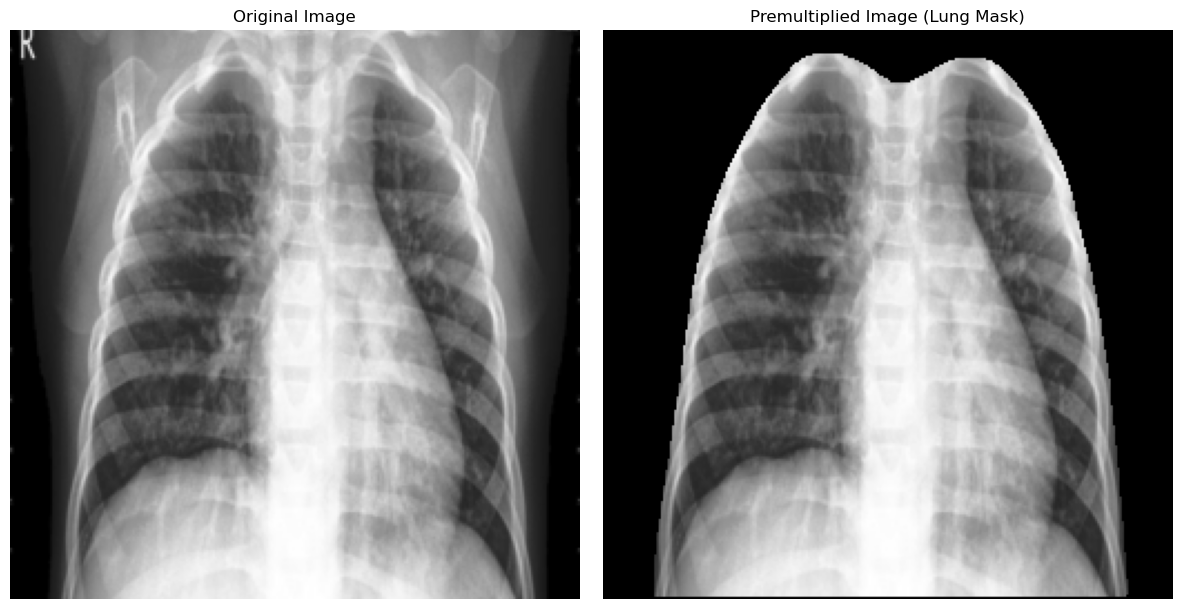

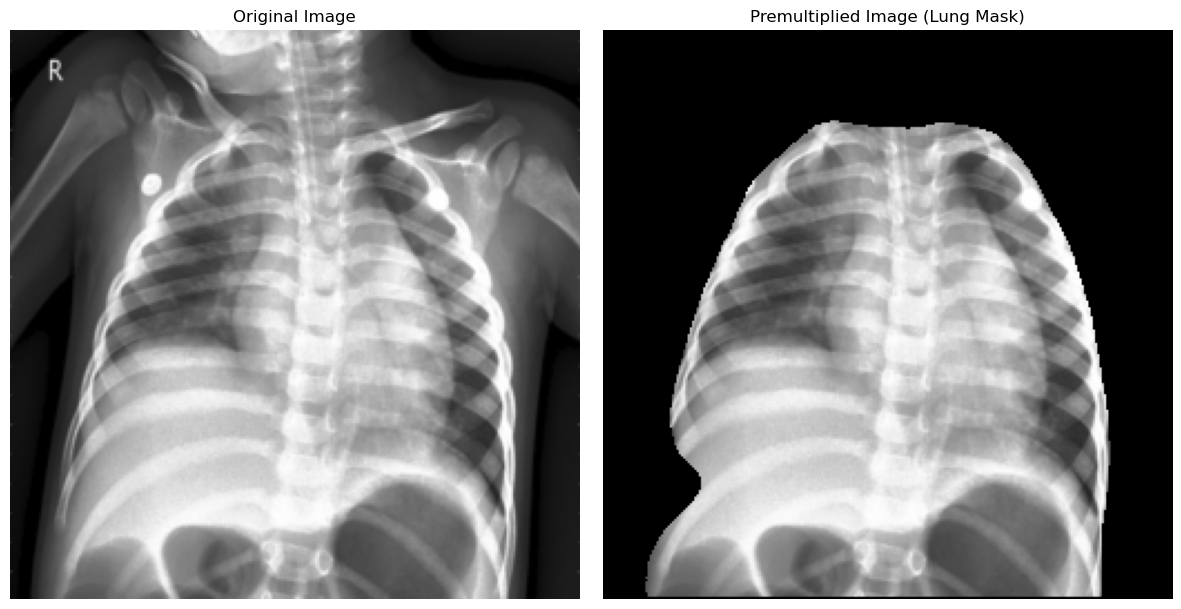

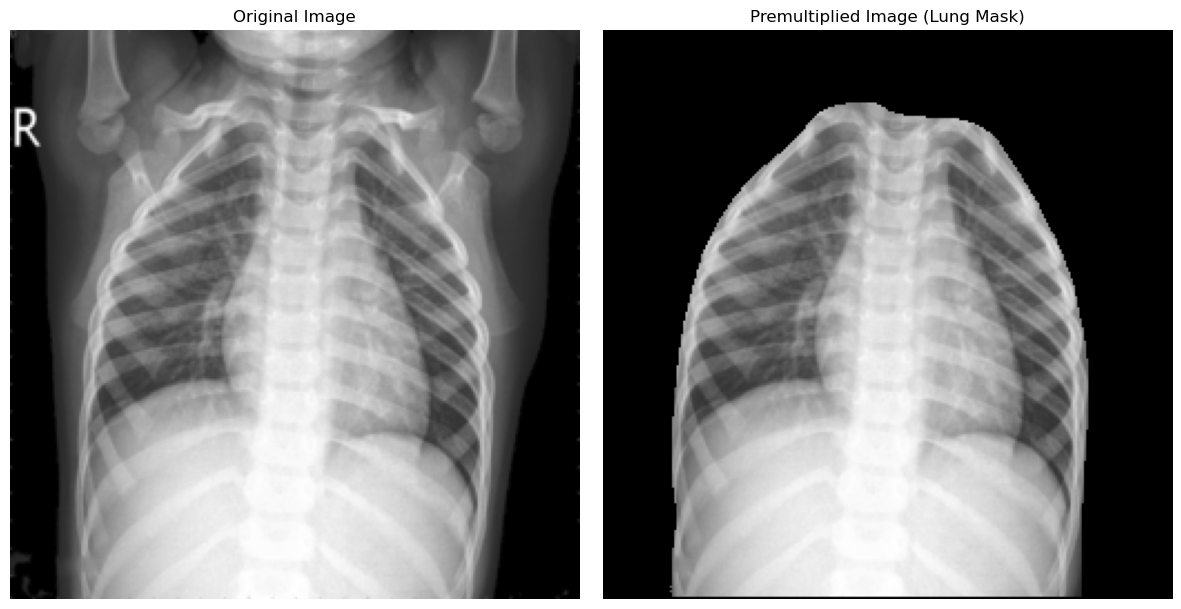

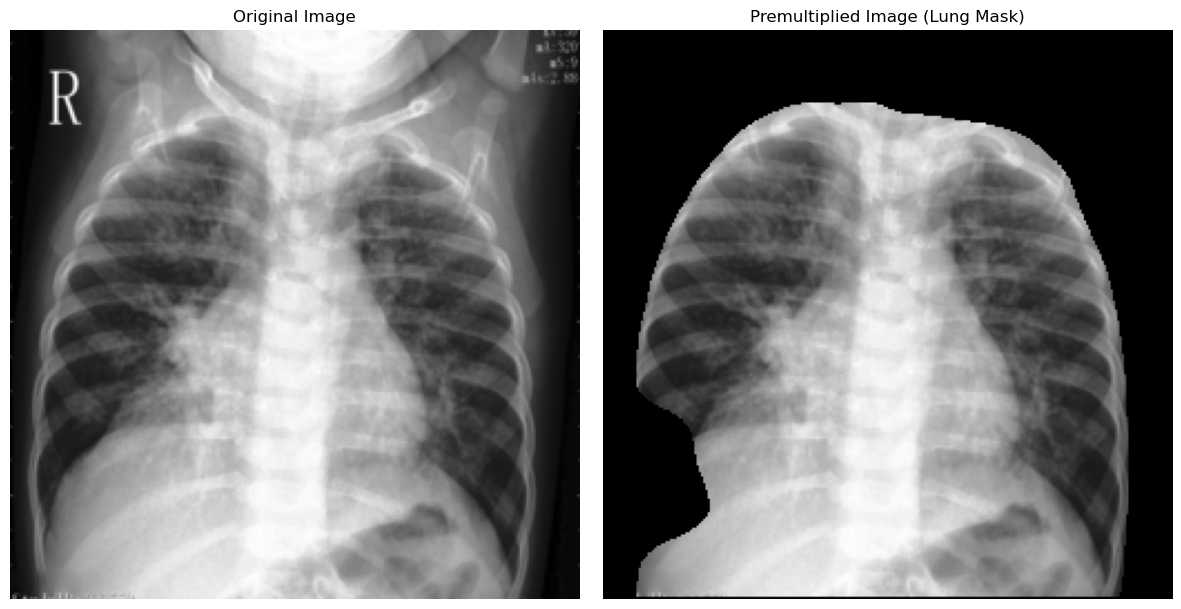

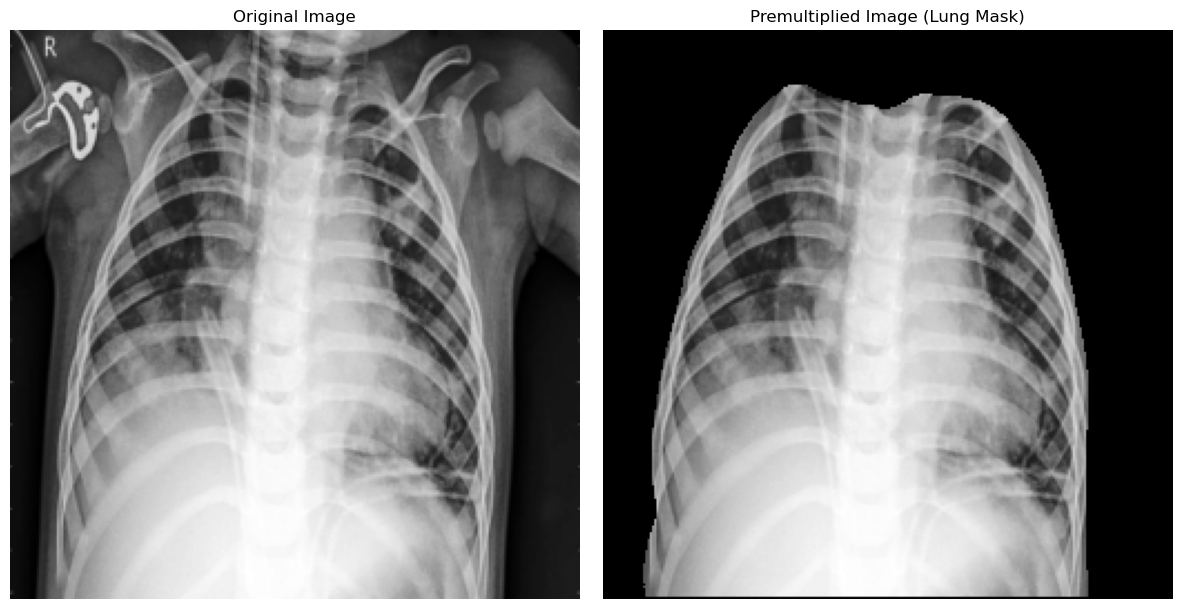

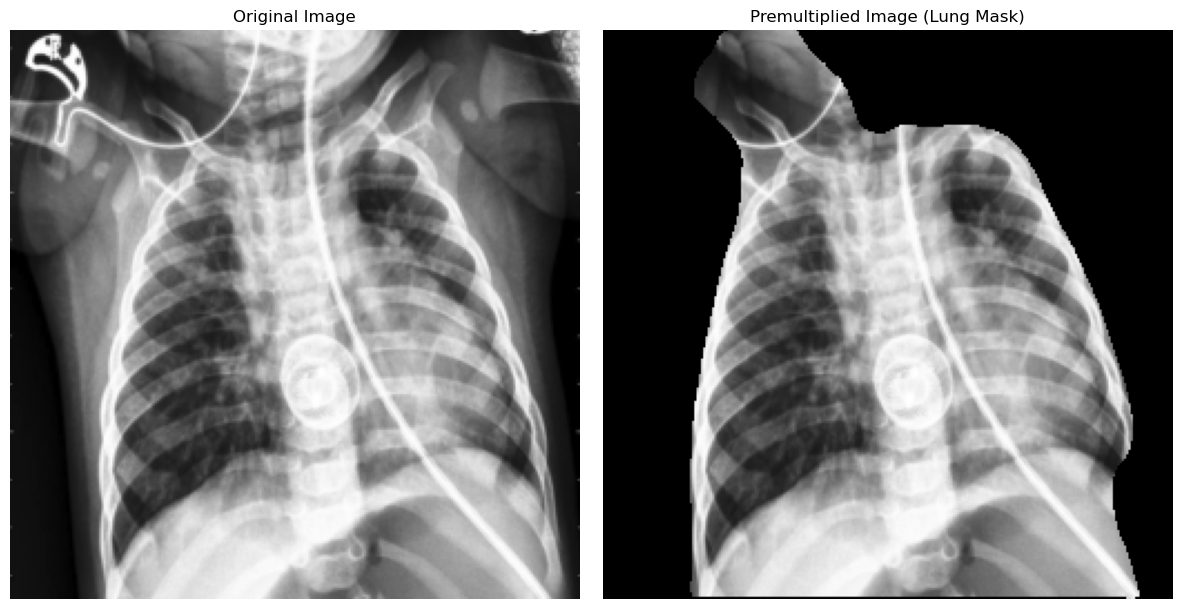

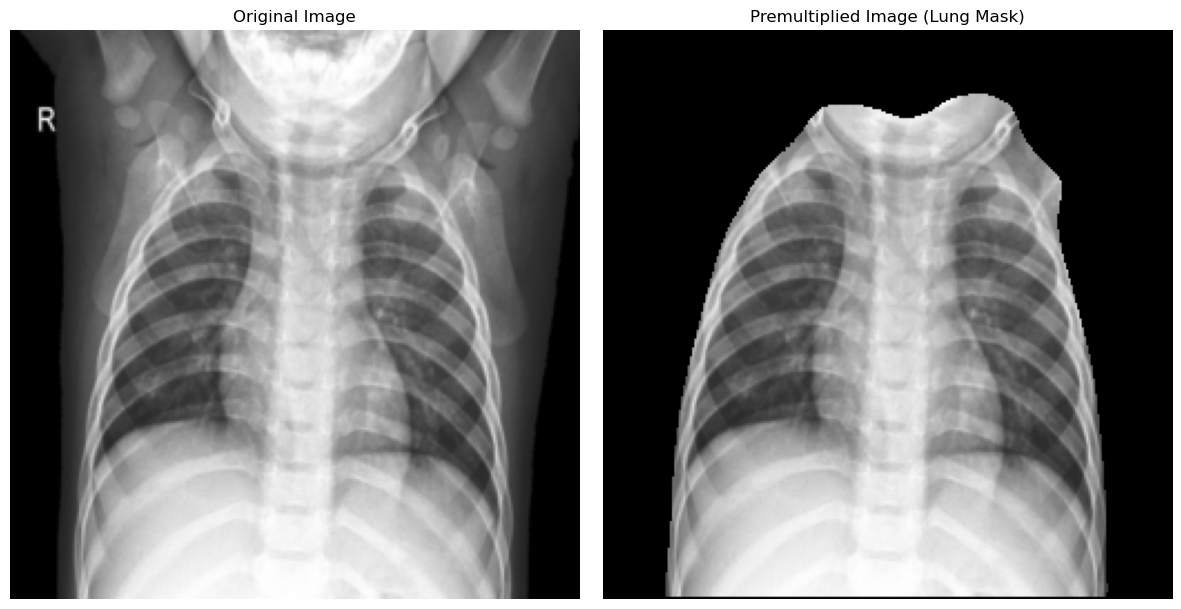

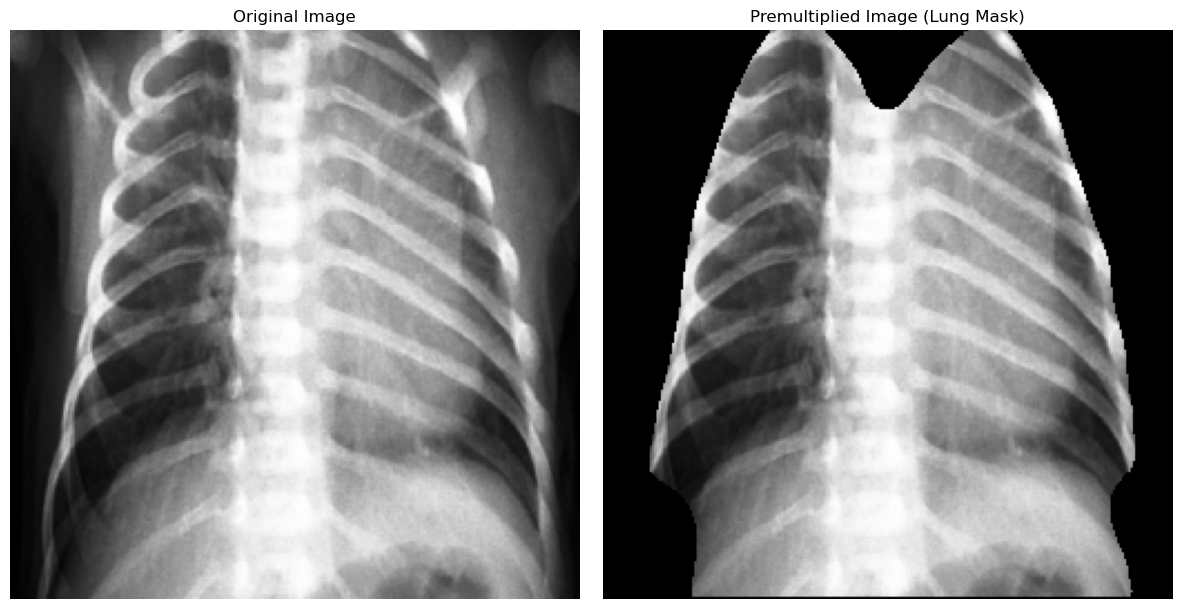

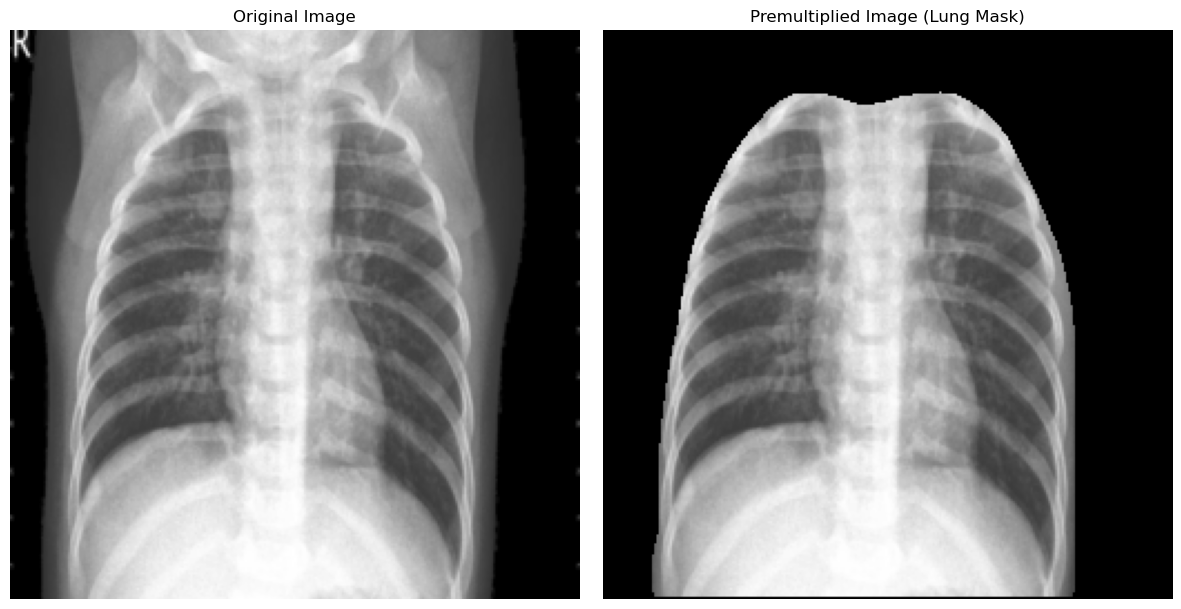

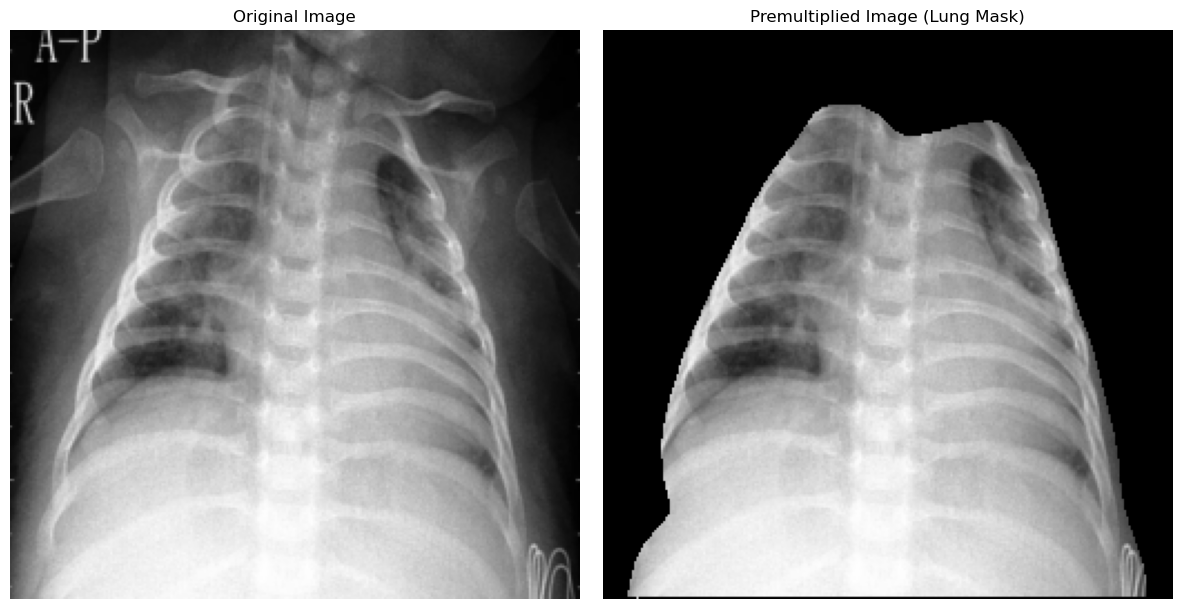

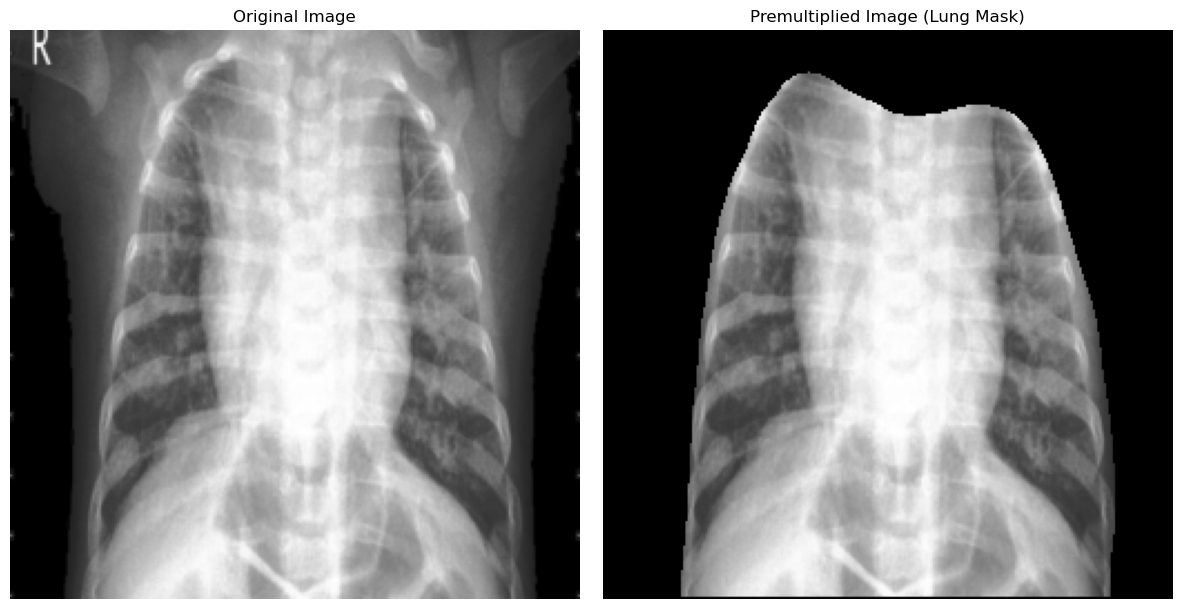

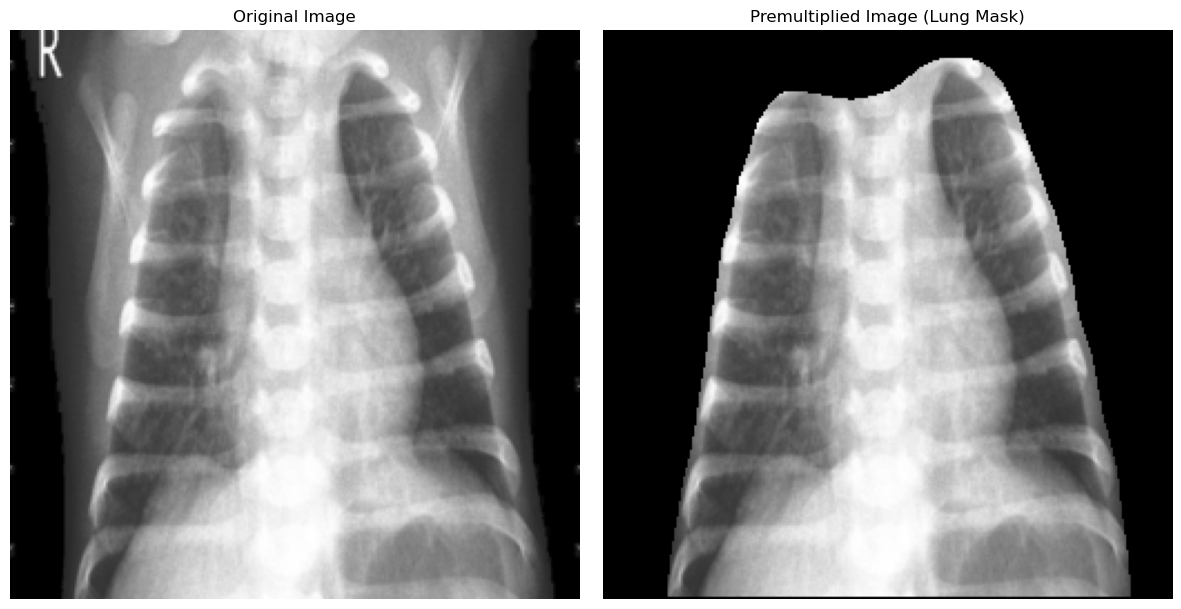

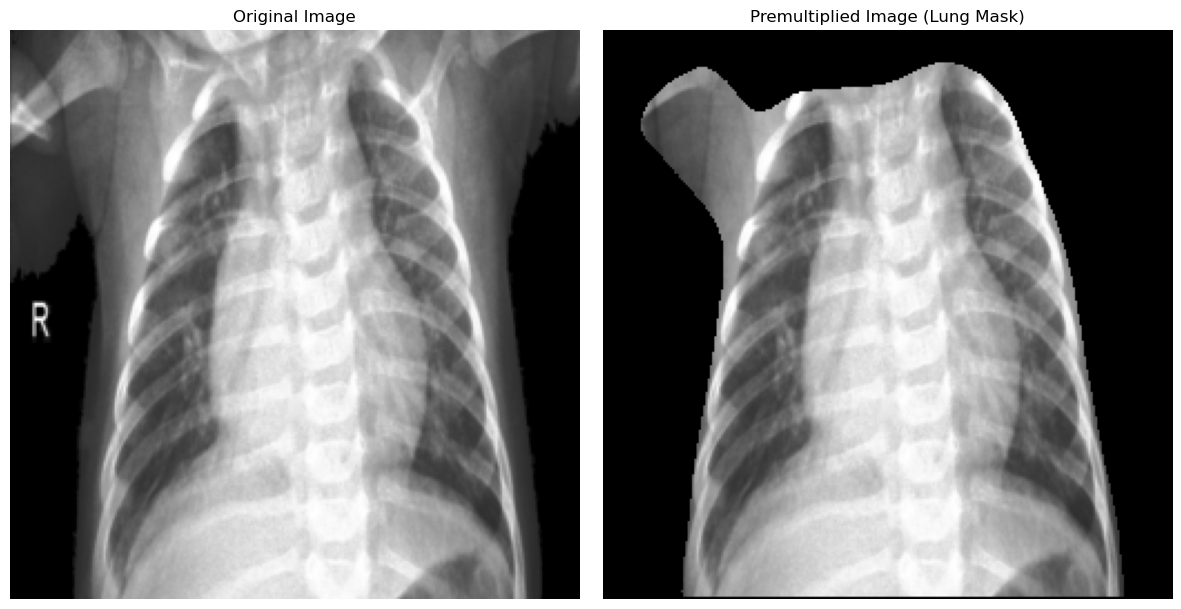

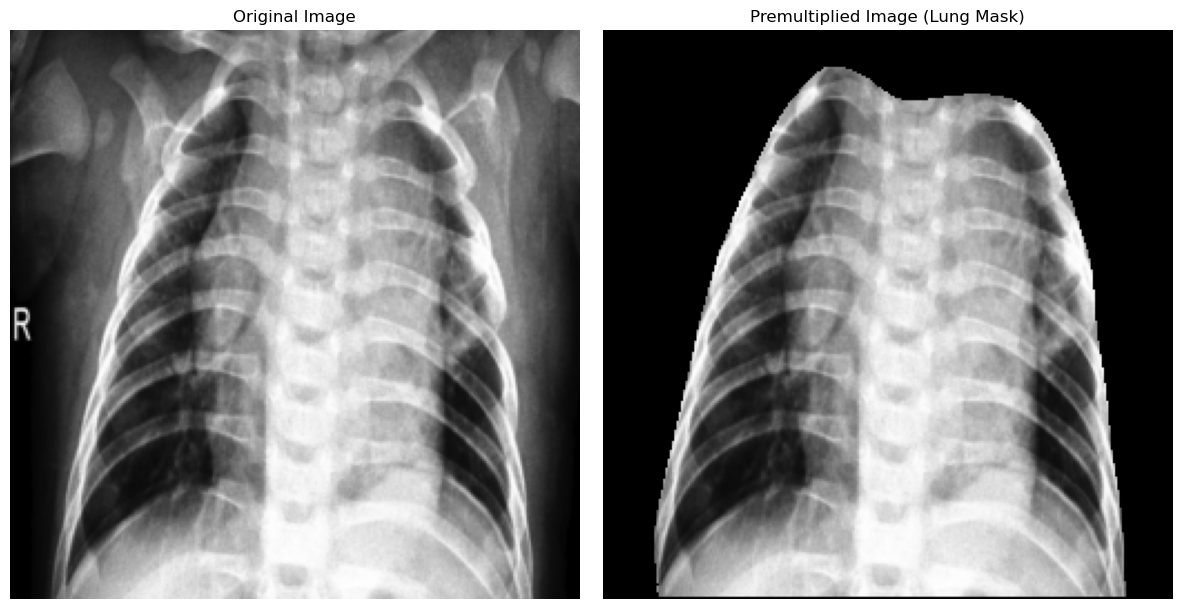

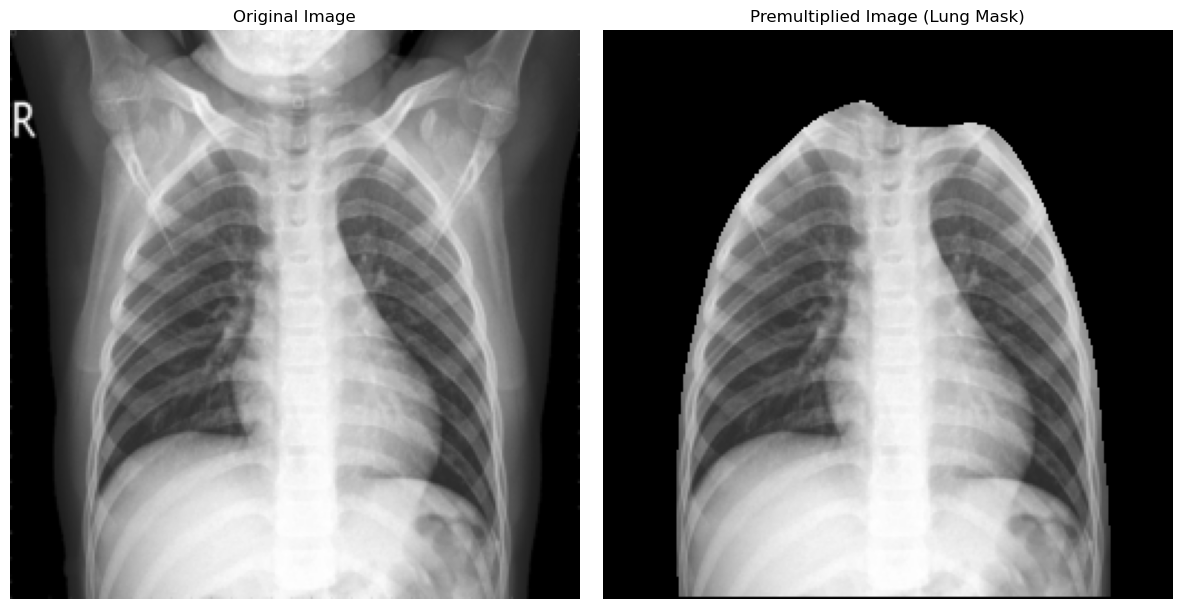

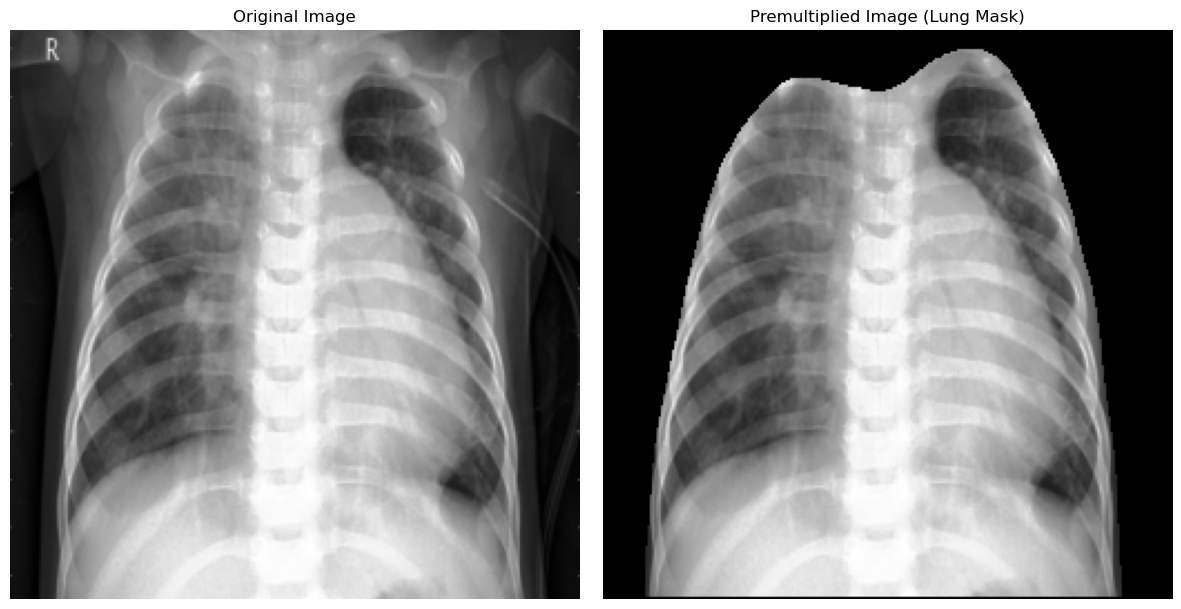

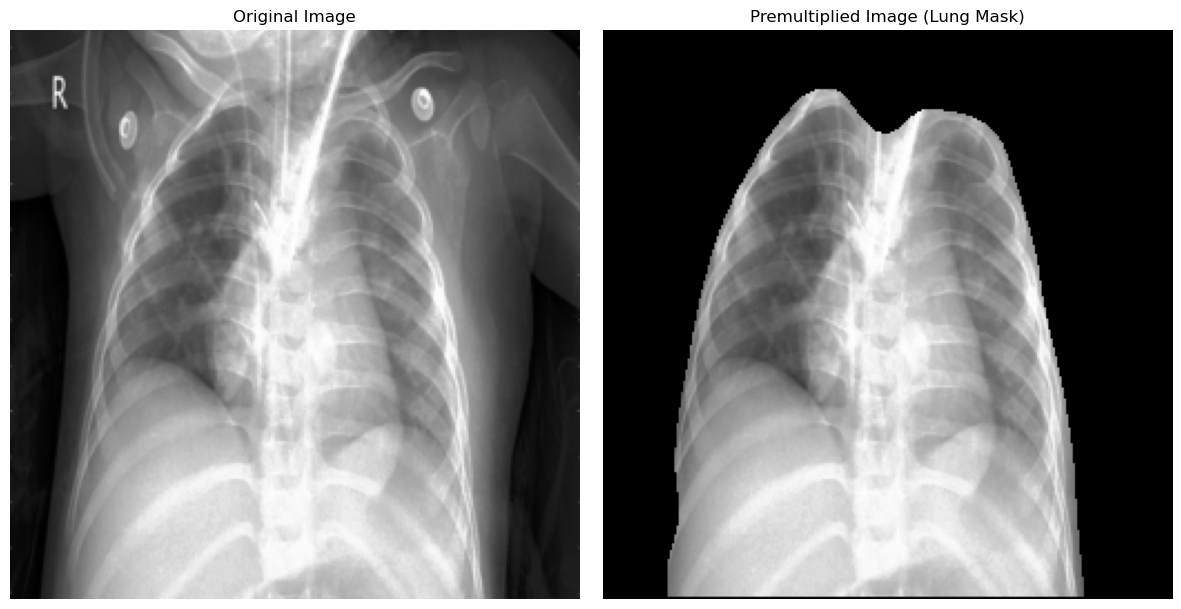

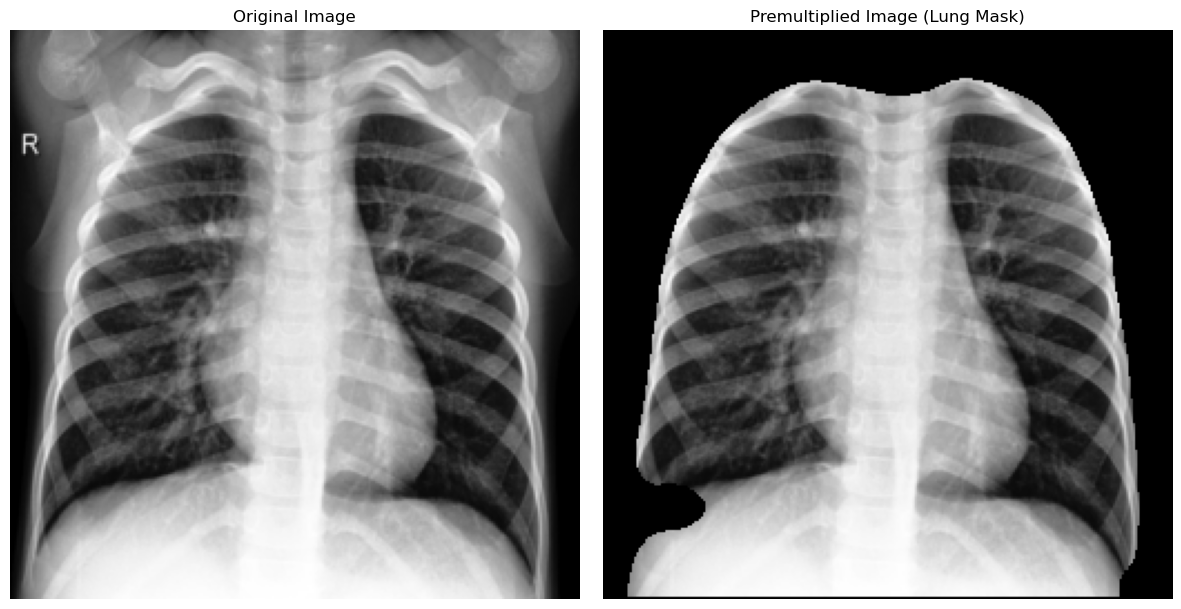

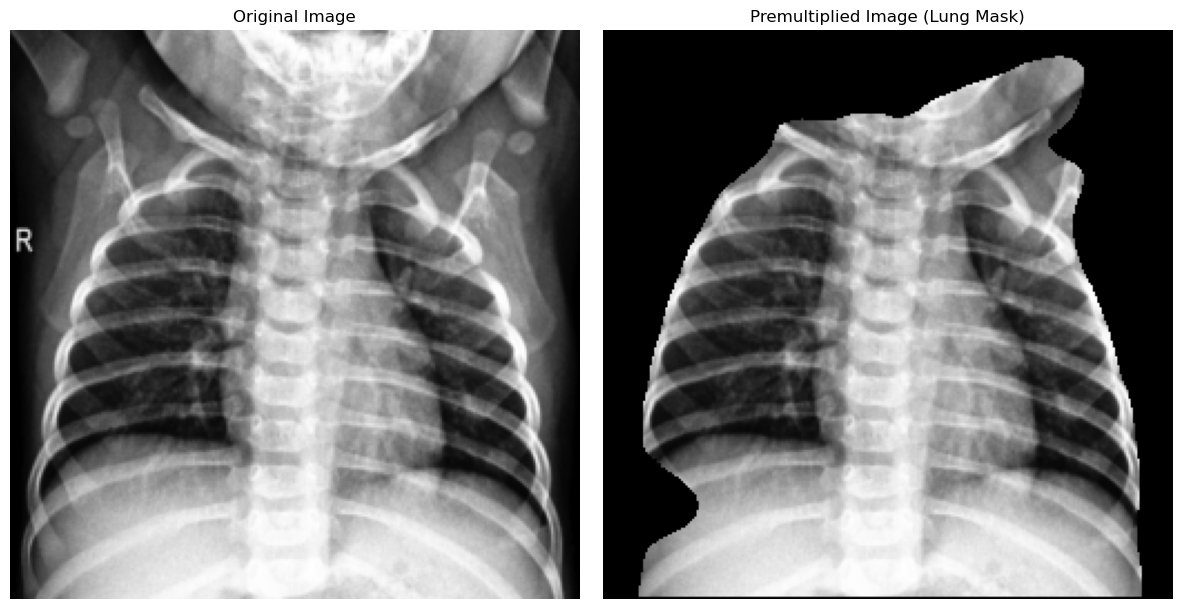

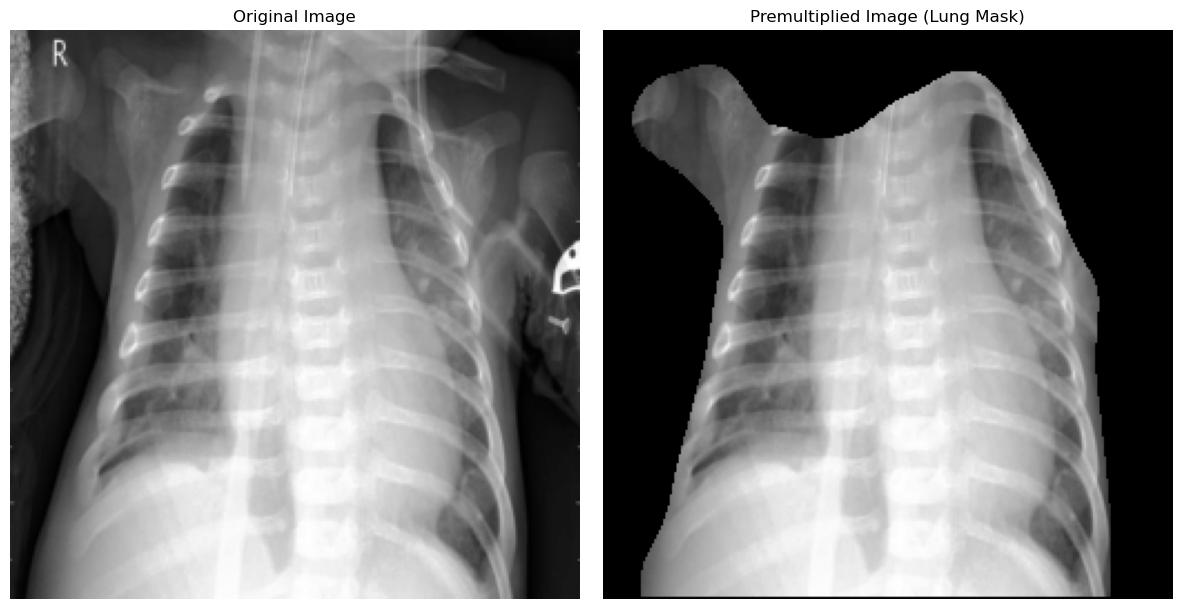

In [67]:
# Example usage
base_folder = "../data/equalized"
output_base_folder = "../data/masked"
model.eval()

# Define transformation for test images
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

predict_and_visualize_all(base_folder, model, test_transform, output_base_folder, plot_count=20)